## Plots of surface anomlies and NAO phases

In this notebook, we plot composite of surface anomaly patters for different diagnostics for postivei and negativev NAO phases. This is to confirm our hypothesis that NAO have strong and direct imprint on surface anomlies in winter seasons. Moreoever, we look at correlations between NAO indices and suraface anomalies. 

In [1]:
# Load libraries

import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler, ProgressBar, visualize

import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_sec(ax, da, vmin=-999, vmax=999, levels=9, lat_lon_ext = [-180, 180, -85., 85.],
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?'):
        
    p = da.plot.contourf(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, levels = levels, cmap=cmap, 
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False, extend='both')
    
    # add separate colorbar
    cb = plt.colorbar(p, ax=ax, extend='both', shrink=0.6) # orientation="horizontal"
    cb.ax.tick_params(labelsize=12)
    
    ax.set_extent(lat_lon_ext, crs=ccrs.PlateCarree())
    
    # parallels/meridiens
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    #gl.ylocator = mticker.FixedLocator([-80, -70, -60, -50, -40, -30])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
    #ax.set_adjustable('datalim')
    #ax.coastlines()
    ax.add_feature(cfeature.LAND) #facecolor='black')
    ax.add_feature(cfeature.COASTLINE)
    ax.set_aspect(1.0)

    #p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    _ = plt.title(title, fontsize=14)
    return fig

### Correlation plots

First we look at spatial patters of correlation between NAO and ocean surface dianostics. In particular, we look at anomalies in surface heat flux, SST, SSS and mixed layer depth. We isolate data for all winter seasons and plot mean of those across ensemble members. To make sure that corelations are reliable, we plot standard deviation in correlation estimates.

Surface heat flux and mixed layer depth anomalies show strong corelations with NAO. SST and SST do not vary as closely. 

In [3]:
ppdir = "/home/users/hkhatri/DePreSys4_Data/Data_Correlation/"

var_list = ['hfds', 'tos', 'sos', 'mlotst']

ds = []

for var in var_list:
    
    d = xr.open_mfdataset(ppdir + var +"/*.nc", combine = 'nested', concat_dim='r')
    
    ds.append(d)
    
ds = xr.merge(ds)

ds = ds.chunk({'r':-1, 'time':1, 'i':-1, 'j':-1})

print(ds)

<xarray.Dataset>
Dimensions:    (time: 41, j: 450, i: 450, r: 10)
Coordinates:
  * time       (time) object 1960-12-01 00:00:00 ... 1970-12-01 00:00:00
  * j          (j) int32 699 700 701 702 703 704 ... 1144 1145 1146 1147 1148
  * i          (i) int32 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
    latitude   (j, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
    longitude  (j, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
Dimensions without coordinates: r
Data variables:
    hfds       (r, time, j, i) float64 dask.array<chunksize=(10, 1, 450, 450), meta=np.ndarray>
    tos        (r, time, j, i) float64 dask.array<chunksize=(10, 1, 450, 450), meta=np.ndarray>
    sos        (r, time, j, i) float64 dask.array<chunksize=(10, 1, 450, 450), meta=np.ndarray>
    mlotst     (r, time, j, i) float64 dask.array<chunksize=(10, 1, 450, 450), meta=np.ndarray>


In [4]:
ds_DJF = ds.sel(time = ds['time.season'] == 'DJF')

ds_mean = ds_DJF.mean(dim = 'r')
ds_std = ds_DJF.std(dim = 'r')

print(ds_mean, ds_std)

<xarray.Dataset>
Dimensions:    (time: 11, j: 450, i: 450)
Coordinates:
  * time       (time) object 1960-12-01 00:00:00 ... 1970-12-01 00:00:00
  * j          (j) int32 699 700 701 702 703 704 ... 1144 1145 1146 1147 1148
  * i          (i) int32 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
    latitude   (j, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
    longitude  (j, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
Data variables:
    hfds       (time, j, i) float64 dask.array<chunksize=(1, 450, 450), meta=np.ndarray>
    tos        (time, j, i) float64 dask.array<chunksize=(1, 450, 450), meta=np.ndarray>
    sos        (time, j, i) float64 dask.array<chunksize=(1, 450, 450), meta=np.ndarray>
    mlotst     (time, j, i) float64 dask.array<chunksize=(1, 450, 450), meta=np.ndarray> <xarray.Dataset>
Dimensions:    (time: 11, j: 450, i: 450)
Coordinates:
  * time       (time) object 1960-12-01 00:00:00 ... 1970-12-01 00:00:00
  * j          (j) int

In [22]:
with Profiler() as prof, ResourceProfiler() as rprof, CacheProfiler() as cprof:
    
    %time data_mean = ds_mean.compute()
    %time data_std = ds_std.compute()

CPU times: user 5.18 s, sys: 10.8 s, total: 16 s
Wall time: 6.91 s


/home/users/hkhatri/.conda/envs/py-xgcm/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CPU times: user 6.16 s, sys: 9.52 s, total: 15.7 s
Wall time: 6 s


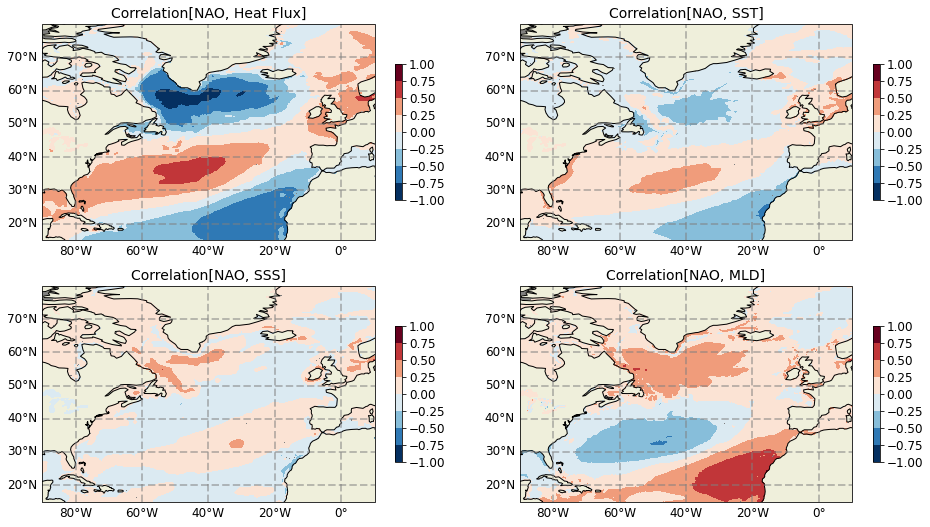

In [59]:
# Plot mean correlations

lat_lon_ext = [-90., 10., 15., 80.]
grid1 = plt.GridSpec(2, 2, wspace=0.15, hspace=0.15)
fig = plt.figure(figsize=[16,9])

i=0 
j=0
count = 0
count1 = 0

name = ['Heat Flux', 'SST' ,'SSS', 'MLD']

for var in var_list:
    
    ax = fig.add_subplot(grid1[i, j], projection=ccrs.PlateCarree(),facecolor='grey')

    tmp = data_mean[var].mean(dim='time') #.isel(time=0) #.assign_coords({'lat': ds['latitude'], 'lon': ds['longitude']})
    titl = 'Correlation[NAO, ' + str(name[count1]) + ']'
    p = plot_sec(ax, tmp, vmin=-1., vmax=1.,  lat_lon_ext = lat_lon_ext, levels = 9,
                 lon='longitude', lat='latitude', cmap='RdBu_r', title=titl)
    
    count = count + 1
    count1 = count1 + 1
    
    if(j==0):
        j = j + 1
    else:
        j = j - 1
    
    if(count > 1):
        i = i + 1
        count = 0

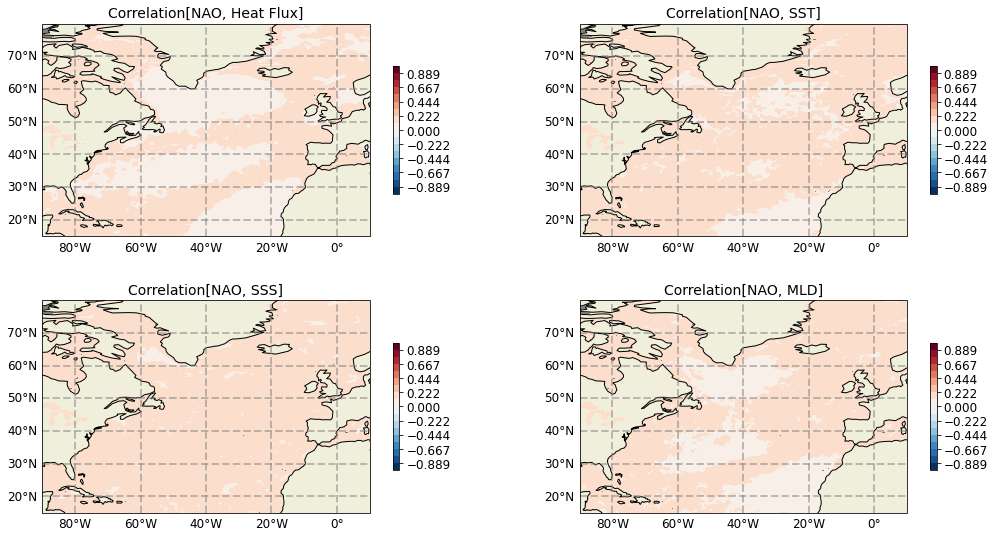

In [60]:
# Plot mean correlations

lat_lon_ext = [-90., 10., 15., 80.]
grid1 = plt.GridSpec(2, 2, wspace=0.15, hspace=0.3)
fig = plt.figure(figsize=[18,9])

i=0 
j=0
count = 0
count1 = 0

name = ['Heat Flux', 'SST' ,'SSS', 'MLD']

for var in var_list:
    
    ax = fig.add_subplot(grid1[i, j], projection=ccrs.PlateCarree(),facecolor='grey')

    tmp = data_std[var].mean('time') #.isel(time=0) #.assign_coords({'lat': ds['latitude'], 'lon': ds['longitude']})
    titl = 'Correlation[NAO, ' + str(name[count1]) + ']'
    p = plot_sec(ax, tmp, vmin=-1, vmax=1,  lat_lon_ext = lat_lon_ext, levels = 19,
                 lon='longitude', lat='latitude', cmap='RdBu_r', title=titl)
    
    count = count + 1
    count1 = count1 + 1
    
    if(j==0):
        j = j + 1
    else:
        j = j - 1
    
    if(count > 1):
        i = i + 1
        count = 0

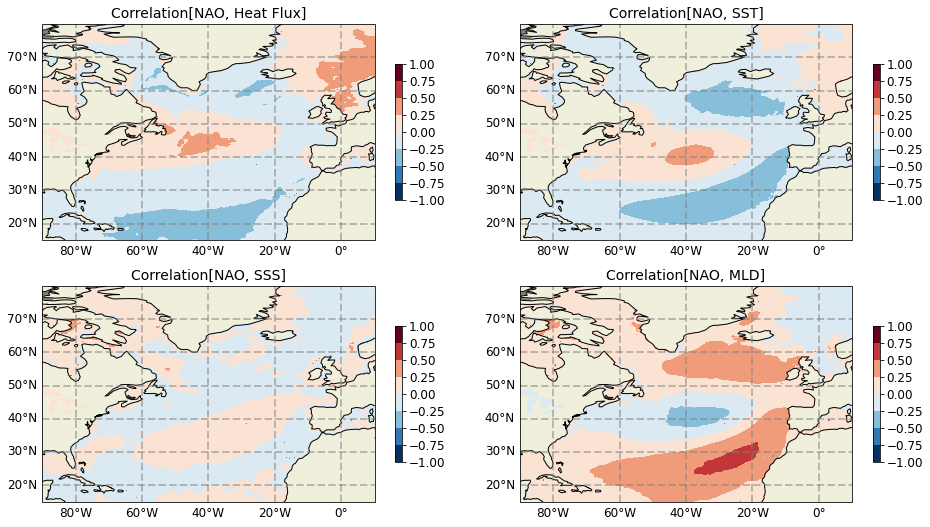

In [62]:
# For JJA season

ds_JJA = ds.sel(time = ds['time.season'] == 'JJA')

ds_mean = ds_JJA.mean(dim = 'r')
ds_std = ds_JJA.std(dim = 'r')

lat_lon_ext = [-90., 10., 15., 80.]
grid1 = plt.GridSpec(2, 2, wspace=0.15, hspace=0.15)
fig = plt.figure(figsize=[16,9])

i=0 
j=0
count = 0
count1 = 0

name = ['Heat Flux', 'SST' ,'SSS', 'MLD']

for var in var_list:
    
    ax = fig.add_subplot(grid1[i, j], projection=ccrs.PlateCarree(),facecolor='grey')

    tmp = ds_mean[var].mean(dim='time') #.isel(time=0) #.assign_coords({'lat': ds['latitude'], 'lon': ds['longitude']})
    titl = 'Correlation[NAO, ' + str(name[count1]) + ']'
    p = plot_sec(ax, tmp, vmin=-1., vmax=1.,  lat_lon_ext = lat_lon_ext, levels = 9,
                 lon='longitude', lat='latitude', cmap='RdBu_r', title=titl)
    
    count = count + 1
    count1 = count1 + 1
    
    if(j==0):
        j = j + 1
    else:
        j = j - 1
    
    if(count > 1):
        i = i + 1
        count = 0

## Composites of surface diagnostics for NAO+ and NAO- phases

In [12]:
ppdir = "/home/users/hkhatri/DePreSys4_Data/Data_Composite/composite/"

ds_NAOp = xr.open_mfdataset(ppdir + "*NAOp*.nc")

ds_NAOn = xr.open_mfdataset(ppdir + "*NAOn*.nc")

print(ds_NAOp, ds_NAOn)

<xarray.Dataset>
Dimensions:    (j: 450, i: 450, comp: 30, lat: 649, lon: 864)
Coordinates:
    time       object 1961-12-01 00:00:00
  * j          (j) int32 699 700 701 702 703 704 ... 1144 1145 1146 1147 1148
  * i          (i) int32 749 750 751 752 753 754 ... 1194 1195 1196 1197 1198
    latitude   (j, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
    longitude  (j, i) float32 dask.array<chunksize=(450, 450), meta=np.ndarray>
  * lat        (lat) float64 -90.0 -89.72 -89.44 -89.17 ... 89.44 89.72 90.0
  * lon        (lon) float64 0.0 0.4167 0.8333 1.25 ... 358.3 358.7 359.2 359.6
Dimensions without coordinates: comp
Data variables:
    hfds       (comp, j, i) float32 dask.array<chunksize=(30, 450, 450), meta=np.ndarray>
    mlotst     (comp, j, i) float32 dask.array<chunksize=(30, 450, 450), meta=np.ndarray>
    sos        (comp, j, i) float32 dask.array<chunksize=(30, 450, 450), meta=np.ndarray>
    tauu       (comp, lat, lon) float32 dask.array<chunksize=(30, 649,

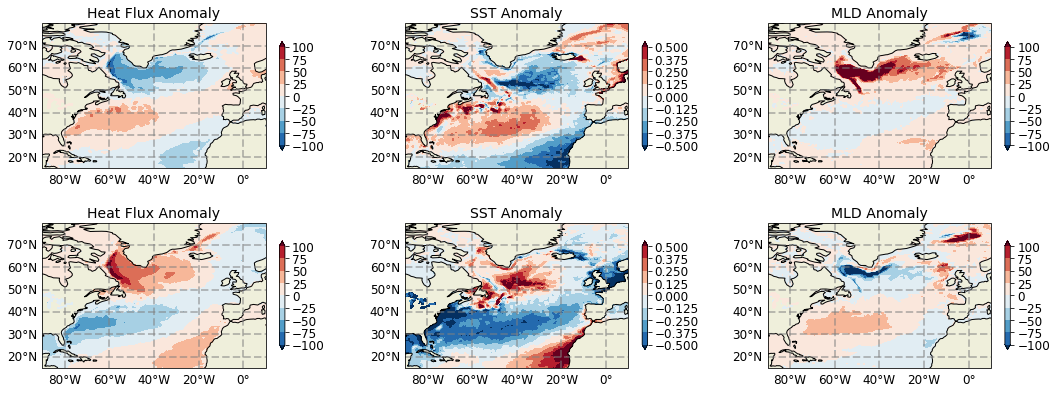

In [13]:
# Plots NAO+ (top) and NAO- (bottom)

grid1 = plt.GridSpec(2, 3, wspace=0.3, hspace=0.1)
fig = plt.figure(figsize=[18,7])

var_list = ['hfds', 'tos', 'mlotst'] #, 'tauu'] 
name = ['Heat Flux Anomaly', 'SST Anomaly' , 'MLD Anomaly', 'Zonal Wind Stress Anomaly']
val = [100., 0.5, 100., 0.1]

lat_lon_ext = [-90., 10., 15., 80.]

count = 0
for var in var_list:
    
    ax = fig.add_subplot(grid1[0, count], projection=ccrs.PlateCarree(),facecolor='grey')
    
    titl = str(name[count])
    
    tmp = ds_NAOp[var].mean(dim='comp')
    
    if(var == 'tauu'):
        #tmp = tmp.assign_coords({'lat': ds['lat'], 'lon': ds['lon']})
        p = plot_sec(ax, tmp, vmin=-val[count], vmax=val[count],  lat_lon_ext = lat_lon_ext, levels = 9,
                     lon='lon', lat='lat', cmap='RdBu_r', title=str(name[count]))
    else:
        p = plot_sec(ax, tmp, vmin=-val[count], vmax=val[count],  lat_lon_ext = lat_lon_ext, levels = 9,
                     lon='longitude', lat='latitude', cmap='RdBu_r', title=str(name[count]))
    
    count = count + 1
    
count = 0
for var in var_list:
    
    ax = fig.add_subplot(grid1[1, count], projection=ccrs.PlateCarree(),facecolor='grey')
    
    titl = str(name[count])
    
    tmp = ds_NAOn[var].mean(dim='comp')
    
    if(var == 'tauu'):
        p = plot_sec(ax, tmp, vmin=-val[count], vmax=val[count],  lat_lon_ext = lat_lon_ext, levels = 9,
                     lon='lon', lat='lat', cmap='RdBu_r', title=str(name[count]))
    else:
        p = plot_sec(ax, tmp, vmin=-val[count], vmax=val[count],  lat_lon_ext = lat_lon_ext, levels = 9,
                     lon='longitude', lat='latitude', cmap='RdBu_r', title=str(name[count]))
    
    count = count + 1

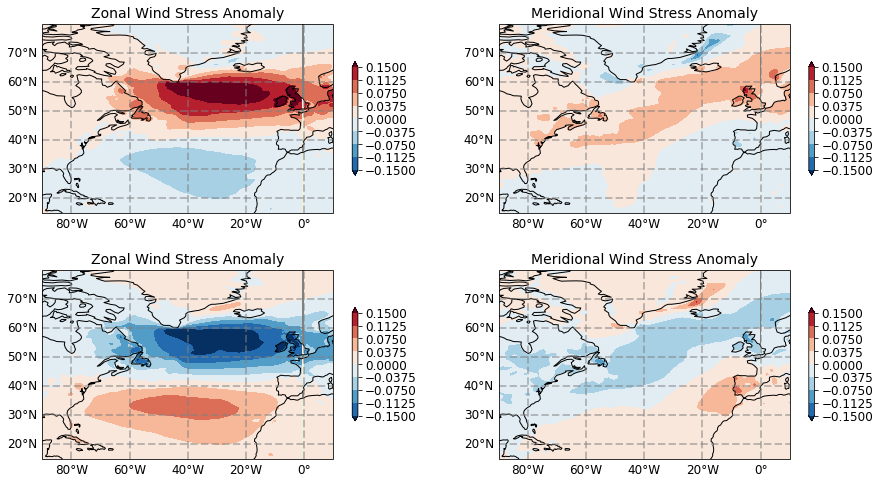

In [10]:
# Plots NAO+ (top) and NAO- (bottom)

grid1 = plt.GridSpec(2, 2, wspace=0.2, hspace=0.3)
fig = plt.figure(figsize=[15,8])

var_list = ['tauu', 'tauv'] 
name = ['Zonal Wind Stress Anomaly', 'Meridional Wind Stress Anomaly']
val = [0.15, 0.15]

lat_lon_ext = [-90., 10., 15., 80.]

count = 0
for var in var_list:
    
    ds_NAOp = xr.open_mfdataset(ppdir + "*NAOp*" + var + "*")
    
    ax = fig.add_subplot(grid1[0, count], projection=ccrs.PlateCarree(),facecolor='grey')
    
    titl = str(name[count])
    
    tmp = ds_NAOp[var].mean(dim='comp')
    
    p = plot_sec(ax, tmp, vmin=-val[count], vmax=val[count],  lat_lon_ext = lat_lon_ext, levels = 9,
                lon='lon', lat='lat', cmap='RdBu_r', title=str(name[count]))
    
    count = count + 1
    
count = 0
for var in var_list:
    
    ds_NAOn = xr.open_mfdataset(ppdir + "*NAOn*" + var + "*")
    
    ax = fig.add_subplot(grid1[1, count], projection=ccrs.PlateCarree(),facecolor='grey')
    
    titl = str(name[count])
    
    tmp = ds_NAOn[var].mean(dim='comp')
    
    p = plot_sec(ax, tmp, vmin=-val[count], vmax=val[count],  lat_lon_ext = lat_lon_ext, levels = 9,
                 lon='lon', lat='lat', cmap='RdBu_r', title=str(name[count]))
    
    count = count + 1

#### Plot DJF hfds, MLD, taux, NAO timeseris together